<a href="https://colab.research.google.com/github/Room1097/ECG_Feature_Analysis_DAV_Project/blob/main/DAV_MINI_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# STEP 0: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")


In [111]:
df = pd.read_csv("a01.csv")

In [112]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,labels
0,-0.060,-0.065,-0.060,-0.075,-0.065,-0.070,-0.070,-0.090,-0.080,-0.095,...,-0.105,-0.080,-0.07,-0.010,-0.03,0.015,0.04,0.070,0.090,0
1,0.140,0.170,0.215,0.245,0.250,0.240,0.240,0.255,0.230,0.180,...,-0.085,-0.080,-0.09,-0.095,-0.10,-0.085,-0.11,-0.095,-0.100,0
2,-0.100,-0.105,-0.105,-0.125,-0.110,-0.110,-0.100,-0.130,-0.110,-0.085,...,-0.060,-0.035,-0.03,-0.045,-0.05,-0.025,-0.04,-0.055,-0.110,0
3,-0.060,-0.085,-0.085,-0.085,-0.090,-0.145,-0.065,-0.130,-0.095,-0.170,...,0.000,0.010,0.00,-0.010,-0.04,-0.025,-0.01,0.030,0.020,0
4,0.025,0.030,0.100,0.115,0.095,0.165,0.185,0.085,0.065,0.015,...,-0.090,-0.080,-0.06,-0.030,0.00,0.030,0.05,0.070,0.115,0


In [113]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,labels
484,-0.150,-0.165,-0.195,0.065,0.770,1.285,0.685,-0.300,-0.705,-0.525,...,-0.045,-0.030,-0.045,-0.035,-0.055,-0.050,-0.045,-0.045,-0.05,1
485,-0.045,-0.040,-0.055,-0.055,-0.060,-0.055,-0.055,-0.045,-0.070,-0.055,...,-0.060,-0.140,-0.210,-0.185,-0.200,-0.175,-0.225,0.020,0.87,1
486,1.740,1.130,-0.455,-0.710,-0.355,-0.135,-0.120,-0.115,-0.100,-0.100,...,-0.020,-0.035,-0.040,-0.045,-0.050,-0.030,-0.055,-0.055,-0.06,1
487,-0.040,-0.080,-0.060,-0.090,-0.060,-0.050,-0.065,-0.055,-0.080,-0.050,...,-0.050,-0.050,-0.055,-0.040,-0.070,-0.060,-0.060,-0.050,-0.05,1
488,-0.045,-0.045,-0.040,-0.045,-0.040,-0.045,-0.040,-0.045,-0.040,-0.045,...,-0.020,0.000,-0.025,-0.025,-0.040,-0.040,-0.050,-0.050,-0.04,1


In [114]:
df.shape

(489, 6001)

In [115]:
ones_count = df.iloc[:, -1].value_counts()[1] if 1 in df.iloc[:, -1].value_counts() else 0
print(f"Number of 1s in the last column: {ones_count}")


Number of 1s in the last column: 470


In [116]:
X_raw = df.iloc[:, :-1]
y = df.iloc[:, -1]

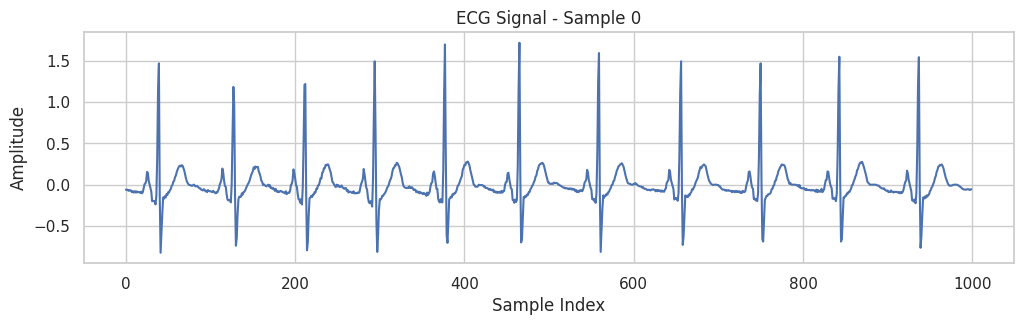

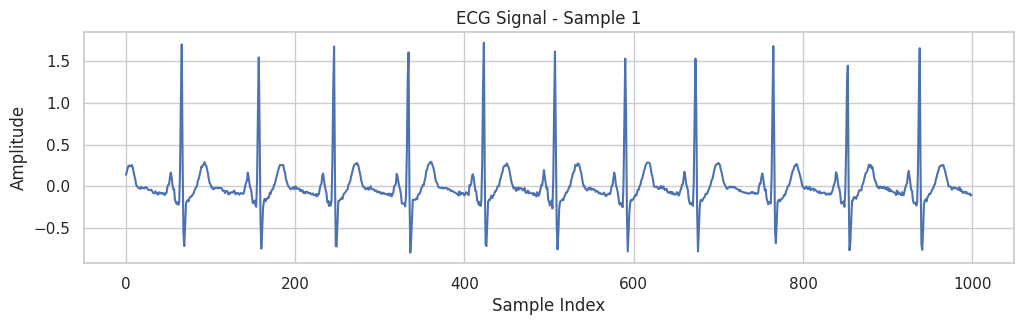

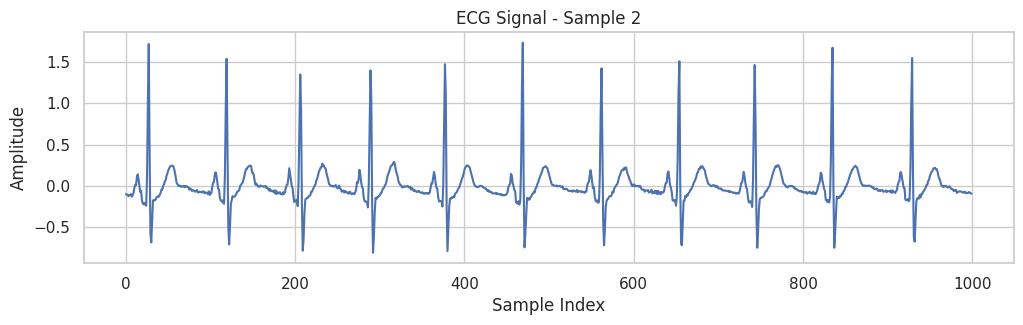

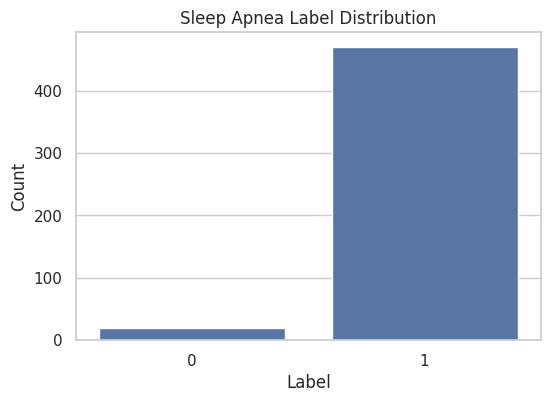

In [117]:
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.plot(X_raw.iloc[i].values[:1000])
    plt.title(f"ECG Signal - Sample {i}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Sleep Apnea Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [118]:
# STEP 3: Feature Extraction

def extract_features(signal):
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['var'] = np.var(signal)
    features['median'] = np.median(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['range'] = np.ptp(signal)
    features['q1'] = np.percentile(signal, 25)
    features['q3'] = np.percentile(signal, 75)
    features['iqr'] = features['q3'] - features['q1']
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['zero_crossings'] = np.count_nonzero(np.diff(np.sign(signal)))
    abs_diff = np.abs(np.diff(signal))
    features['abs_diff_mean'] = np.mean(abs_diff)
    features['abs_diff_std'] = np.std(abs_diff)
    features['symmetry'] = np.mean(np.abs(signal - signal[::-1]))
    features['signal_energy'] = np.sum(signal**2)
    hist, _ = np.histogram(signal, bins=100, density=True)
    features['signal_entropy'] = entropy(hist + 1e-6)
    freqs, psd = welch(signal, fs=250)
    total_power = np.sum(psd)
    vlf = np.sum(psd[(freqs >= 0.003) & (freqs < 0.04)])
    lf = np.sum(psd[(freqs >= 0.04) & (freqs < 0.15)])
    hf = np.sum(psd[(freqs >= 0.15) & (freqs < 0.4)])
    features['total_power'] = total_power
    features['vlf_power'] = vlf
    features['lf_power'] = lf
    features['hf_power'] = hf
    features['lf_hf_ratio'] = lf / (hf + 1e-6)
    peaks, _ = find_peaks(signal, distance=50, height=np.mean(signal))
    rr_intervals = np.diff(peaks) if len(peaks) > 1 else [0]
    features['num_beats'] = len(peaks)
    features['mean_rr'] = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    features['std_rr'] = np.std(rr_intervals) if len(rr_intervals) > 0 else 0
    features['min_rr'] = np.min(rr_intervals) if len(rr_intervals) > 0 else 0
    features['max_rr'] = np.max(rr_intervals) if len(rr_intervals) > 0 else 0
    features['heart_rate'] = (60 / (features['mean_rr'] / 250)) if features['mean_rr'] > 0 else 0
    return features

# Extract for all samples
feature_list = [extract_features(row) for row in X_raw.values]
X_features = pd.DataFrame(feature_list)


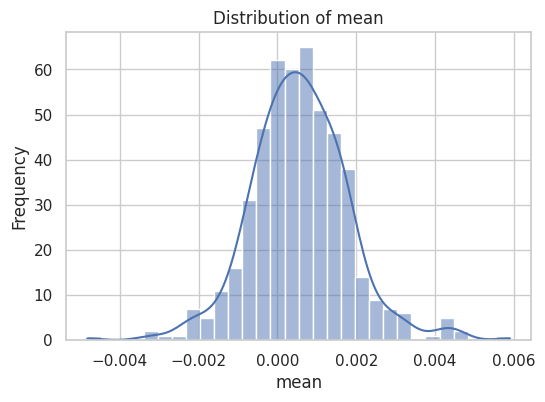

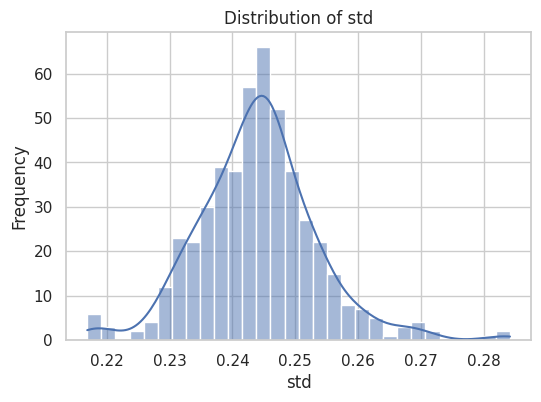

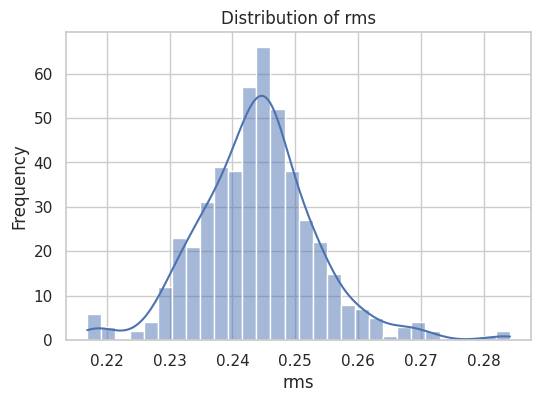

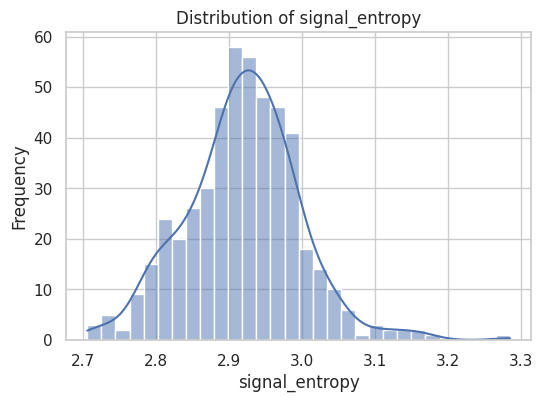

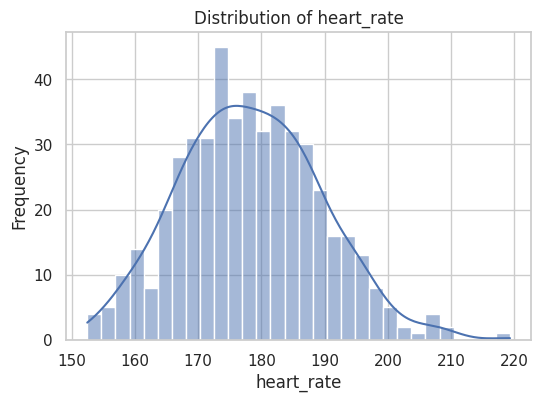

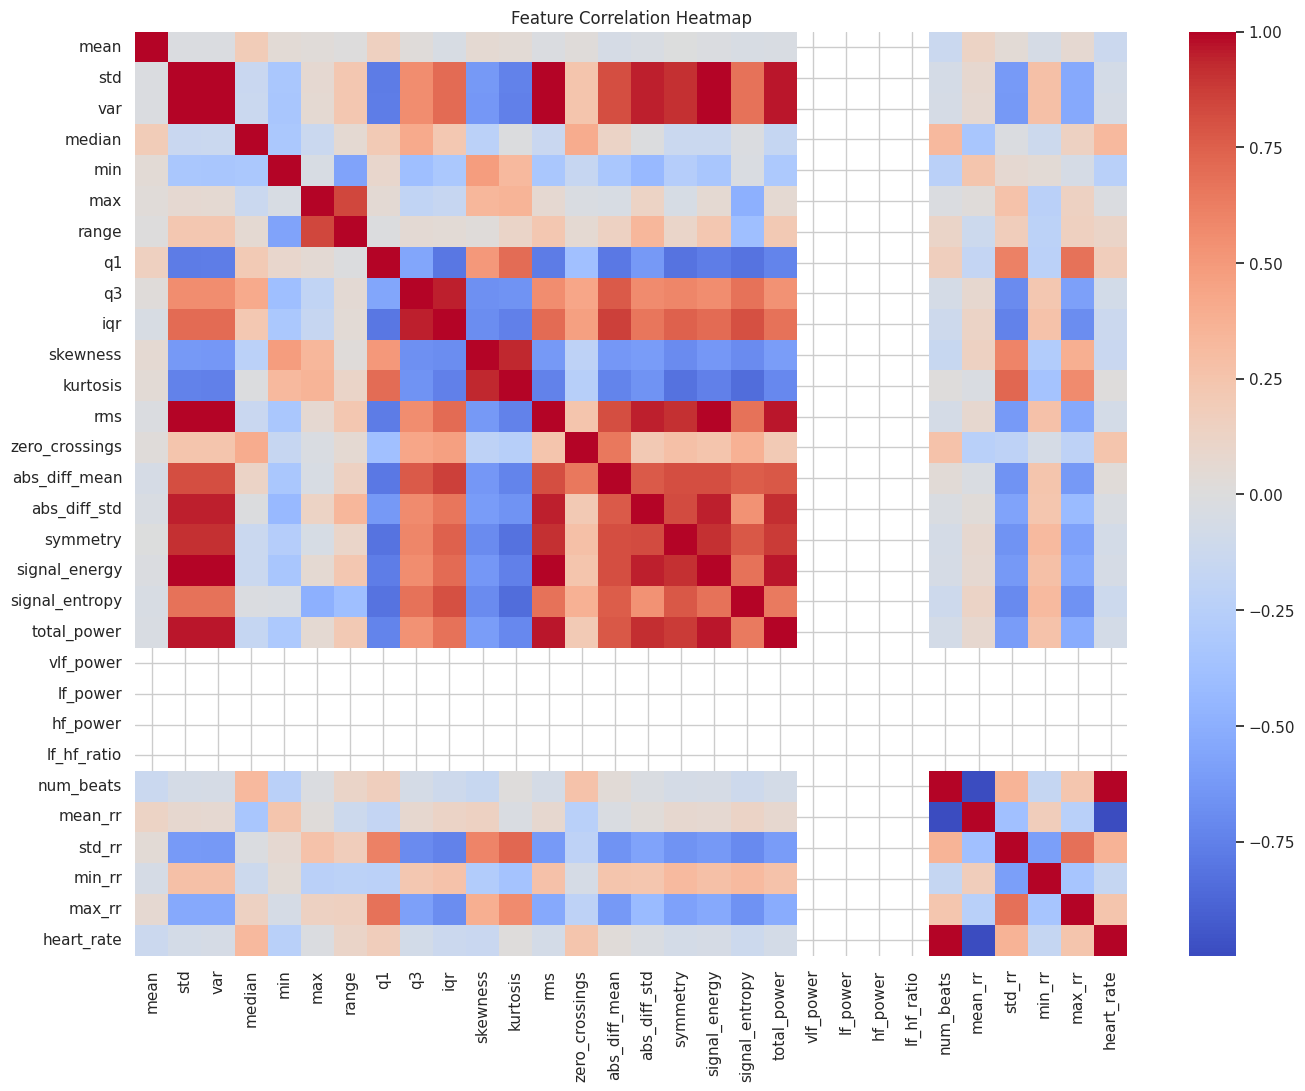

In [119]:
# STEP 4: Feature Visualization

# Histogram of selected features
for feat in ['mean', 'std', 'rms', 'signal_entropy', 'heart_rate']:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_features[feat], bins=30, kde=True)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(X_features.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

In [121]:
# Step 1: Remove constant features
constant_filter = VarianceThreshold(threshold=0.0)
X_no_constants = constant_filter.fit_transform(X_features)
filtered_feature_names = X_features.columns[constant_filter.get_support()]

# Step 2: Scale the filtered features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_constants)

# Step 3: Select top K features (adjust k if needed)
k = min(15, X_scaled.shape[1])  # Just in case fewer than 15 features remain
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Step 4: Get names of selected features
selected_mask = selector.get_support()
selected_feature_names = filtered_feature_names[selected_mask]

print("Selected Features:\n", list(selected_feature_names))

Selected Features:
 ['std', 'var', 'max', 'range', 'q1', 'skewness', 'kurtosis', 'rms', 'symmetry', 'signal_energy', 'signal_entropy', 'total_power', 'std_rr', 'min_rr', 'max_rr']


In [122]:
# STEP 6: Dimensionality Reduction (PCA)

pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(X_selected)
print(f"PCA reduced shape: {X_reduced.shape}")


PCA reduced shape: (489, 6)


In [123]:
# STEP 7: Resample to Fix Imbalance & Split

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_reduced, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


In [124]:
# STEP 8: Train Classifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9787234042553191
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        87
           1       0.99      0.97      0.98       101

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



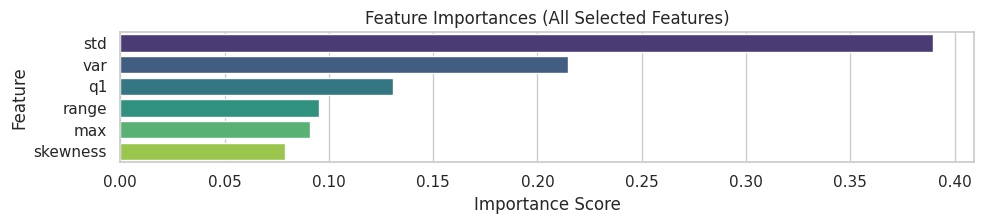

In [125]:
# STEP 9: Plot Feature Importances for All Selected Features

# Get importances from classifier
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Use correct selected feature names (after VarianceThreshold + SelectKBest)
selected_feature_names = filtered_feature_names[selector.get_support()]

# Sort selected features and their importances
sorted_feature_names = [selected_feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, len(sorted_feature_names) * 0.4))
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette="viridis", hue=sorted_feature_names)
plt.title("Feature Importances (All Selected Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
